# Training on standardized data

After discussion with Hsuan-Tien and Yu-Wen, two possible solutions I can try are:
1.  Reduce the distance between the max and minimum of the spectral counts. Recommended ways are:
    -   Use the log of the spectral counts
    -   Standardize the spectral counts (Z score)
1.  Modify the loss function to be more aggresive on the high spectral counts, whcih are much rare than low councts (i.e. data imbalance). This may harmonize the model's preference on predicting moderate counts.
    -   BTW, the higher predicted spectral counts in the unmasked low value parts may be solved by including the loss of those unmasked parts. Since the mask ratio is pretty high and our observed phenomenon, counting only loss on the masked parts is not necessary.

In this notebook, I will try the first solution using standardization. I choose it instead of logrithm because I don't want to replace the 0s (a lot in a spectrum) with some fixed small values. Also, because the data space is largely changed, I guess the learning rate should be adjusted.

## Functions

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from test_mask_ratio import get_dataloader
import pandas as pd

def eval(model, spe_arr):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(24)
        spe = torch.from_numpy(spe_arr)
        return model(spe.unsqueeze(0).float())
    
def unpatchify(mask, pred, model):
    pred_un = model.unpatchify(pred)
    pred_un_arr = pred_un.squeeze(0).numpy()

    mask_arr = mask.squeeze(0).numpy()
    mask_un_arr = np.array([])
    for i in mask_arr:
        mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))
    mask_un_arr = mask_un_arr.astype(int)

    return pred_un_arr, mask_un_arr

def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    channel = np.arange(1, len(spe_arr)+1)
    ax.vlines(channel, ymin=pred_un_arr.min(), ymax=mask_un_arr*spe_arr.max(), color='gray', alpha=0.3, label='masked')
    ax.plot(channel, spe_arr, alpha=.8, label='raw')
    ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
    ax.set_xlim(-1, 2050)
    #ax.set_ylim(0, spe_arr.max())
    ax.set_ylabel('Standardized counts')

    ax.set_xlabel('Channel')
    ax.legend()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
lr_df = pd.read_csv('results/test_lr_20231211.csv')
lr_df

,lr,min_val_loss
0,1.000000e-03,0.059634
1,1.000000e-04,0.024776
2,1.000000e-05,0.021142
3,1.000000e-06,0.059549
4,1.000000e-07,0.431091


Text(0, 0.5, 'Minimum validation loss in 100 epochs')

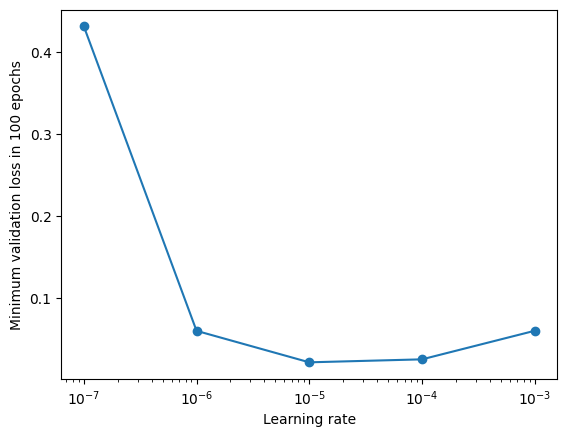

In [3]:
plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Minimum validation loss in 100 epochs')

The best learning rate is 1e-05.

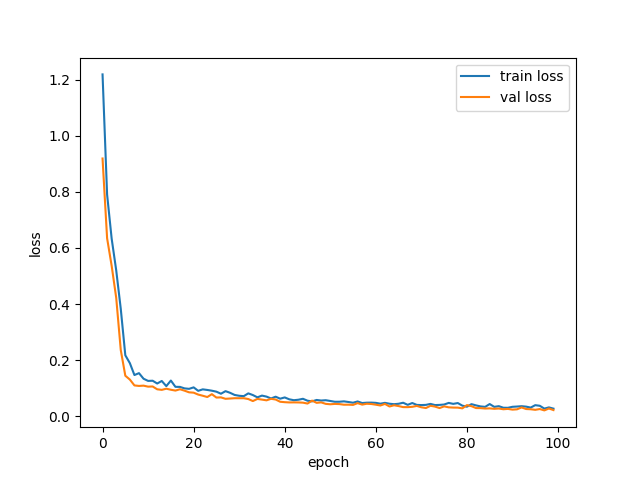

In [5]:
from IPython.display import Image
Image(filename='results/loss_1e-05_20231211.png')

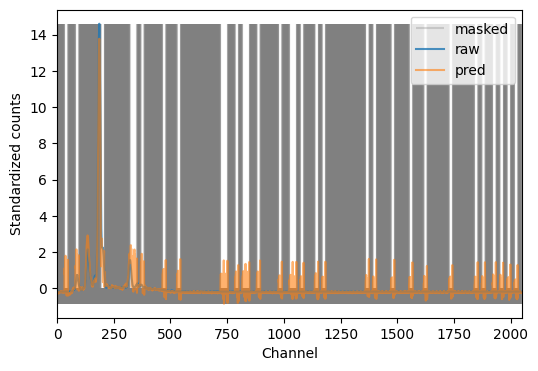

In [15]:
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_1e-05_20231211.pth'))

dataloader = get_dataloader(batch_size=64)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

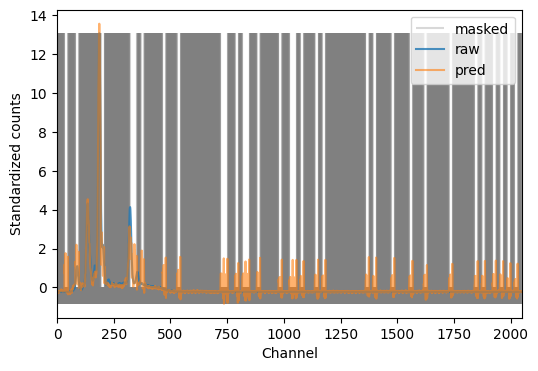

In [16]:
# inference on the validation set
spe_arr = dataloader['val'].dataset[60]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

In [19]:
# 0: unmasked, 1: masked
print(
        'loss of the masked part ({}): {:.3f}'.format(
            mask_un_arr.sum(),
            ((pred_un_arr - spe_arr)**2 * mask_un_arr).sum() / mask_un_arr.sum()
        )
)

print(
        'loss of the unmasked part ({}): {:.3f}'.format(
            (mask_un_arr==0).sum(),
            ((pred_un_arr - spe_arr)**2 * (mask_un_arr==0)).sum() / (mask_un_arr==0).sum()
        )
)

loss of the masked part (1536): 0.009
loss of the unmasked part (512): 0.600


## Discussion
The loss converges in every learning rates. The losses reduce faster and smaller. How smaller the loss is stands for good is tricky because the data is standardized. By looking at the original and predicted spectral counts, the model does doing better job. The extreme values mostly arr predicted well. The benifit of standardization is clear. The issue of imbalance is not the major issue now.

The miss predictions mostly happen on the unmasked parts (no mater high or low spectral counts). The loss of unmasked parts is way higher than the masked parts. I think I can modify the loss function to include the unmasked parts.

### NAN in the loss
The loss is NAN when the learning rate is 1e-03 at the 58th epoch (both training and validation). Below are the possible reasons from Copilot about NAN in loss:

--------------------
1. **Learning Rate**: If the learning rate is too high, the model might overshoot the optimal point during gradient descent, leading to instability and `NaN` values.

2. **Numerical Stability**: Certain operations like logarithms or divisions can result in `NaN` if not handled properly. For example, taking the log of zero or dividing by zero.

3. **Initialization**: Poor initialization of weights can lead to vanishing or exploding gradients, which can cause `NaN` loss.

4. **Data Issues**: If your dataset contains `NaN` values, these can propagate through your model and cause `NaN` loss.

5. **Bug in the Code**: There might be a bug in the model's code that's causing the `NaN` values.

To debug this, you could try reducing the learning rate, checking your data for `NaN` values, or adding print statements in your model to see where the `NaN` values first appear.

--------------------

**Me thinking**: There is no zero, NAN in the data. Otherwise, the loss should be NAN in the first epoch. There should be no bugs causing NAN in the loss. Otherwise, the model shouldn't work before. I guess with the bad initialization, the NAN should pop up in the first epoch, also. Hence, my guess is the first one, learning rate too high. Especially, the later training with high learning rate shows no NAN in the loss.

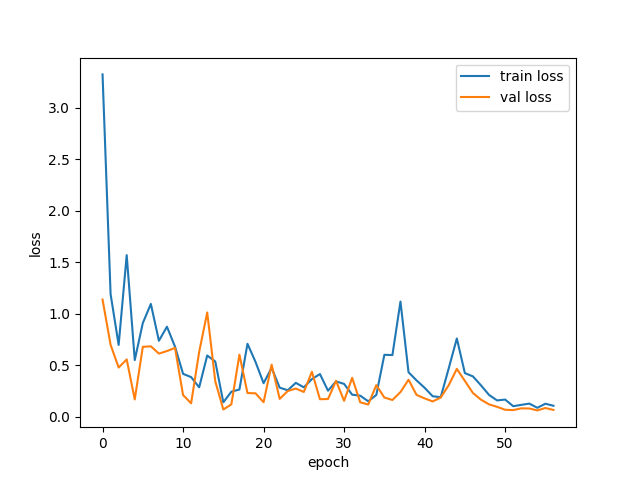

In [17]:
from IPython.display import Image
Image(filename='results/loss_0.001_20231211.png')